# XGBoostによる分類モデルのテスト
最適なパラメータを探す
## データ準備

In [172]:
import re
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import nltk
import torch
from pprint import pprint
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.metrics._scorer import _SCORERS
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from transformers import AutoModel

c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [142]:
df = pd.read_csv("./fake_job_postings.csv")
df = df.drop("job_id", axis=1) # job_id = 0,1,2,... 学習価値なし
# df.fillna('null', inplace=True) # 空の文字列 -> null (XGBoost APIでは無くてもいける？)

# 偽文書と本物文書
Fakedf = df[ df['fraudulent'] == 1 ]
Realdf = df[ df['fraudulent'] == 0 ]

# 問題文データのランダム抽出 (偽文書割合50%)
detaset_Fake, quiz_Fake = train_test_split(Fakedf, test_size=50)
detaset_Real, quiz_Real = train_test_split(Realdf, test_size=50)

# 問題文データのランダムシャッフル
quizdf = pd.concat([quiz_Real, quiz_Fake])
shuffled_df = quizdf.sample(frac=1).reset_index(drop=True)
quiz = shuffled_df.drop("fraudulent", axis=1)        # 問題文
quiz_solution = shuffled_df["fraudulent"].to_numpy() # 解答

# 訓練データとテストデータへの分割 (テストデータ25%)
train_Fake, test_Fake = train_test_split(detaset_Fake)
train_Real, test_Real = train_test_split(detaset_Real)
traindf = pd.concat([train_Real, train_Fake])
testdf = pd.concat([test_Real, test_Fake])
traindf = traindf.sample(frac=1).reset_index(drop=True)
testdf = testdf.sample(frac=1).reset_index(drop=True)
train_X = testdf.drop('fraudulent', axis=1)
train_y = testdf['fraudulent']
test_X = testdf.drop('fraudulent', axis=1)
test_y = testdf['fraudulent']

データの傾向を確認する。

In [143]:
train_X.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function
0,Seeking Hospitality Security Professionals for...,"US, NY, New York",NaN,NaN,NaN,***PLEASE READ ENTIRE JOB DESCRIPTION AND SEE ...,Must be 21 or overHigh School diploma or G.E....,Paid days off after 1 year of full time employ...,0,0,1,Full-time,Not Applicable,High School or equivalent,Security and Investigations,NaN
1,Director of IT,"US, NY, New York",NaN,NaN,Industrial Color Software is a division of Ind...,The Director of IT is responsible for planning...,• 2+ years of experience managing an IT team...,Industrial Color offers competitive benefits i...,0,1,0,Full-time,Not Applicable,Bachelor's Degree,Computer Software,Management
2,Purolator International - Pricing Financial An...,"US, NY, Jericho",NaN,NaN,Pricing Recruiters is the leading global resou...,Working at Purolator International is more tha...,Responsible for supporting corporate profit ma...,Purolator International Provides Competitive B...,0,1,0,Full-time,NaN,NaN,NaN,NaN
3,General Manager - Knoxville,"US, TN, Knoxville",Operations,NaN,"Shyp is the easiest way to send anything, anyw...",Shyp is looking for the best of the best to le...,"5+ years experience with building, managing, a...",Opportunity to play a huge role in a unicorn s...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Logistics and Supply Chain,Management
4,Customer Service Team Lead,"US, AZ, Tempe",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",We are currently seeking a Customer Service Te...,Required Qualifications:Experience coordinatin...,NaN,0,1,0,Full-time,Entry level,High School or equivalent,Facilities Services,Customer Service


カテゴリカルデータの値と頻度を確認

In [144]:
category_columns = ['location','department','salary_range','employment_type','required_experience','required_education','industry','function']
for cc in category_columns:
    print(f"---{cc}---")
    pprint(train_X[cc].value_counts())

---location---
location
GB, LND, London          172
US, NY, New York         162
US, CA, San Francisco    121
GR, I, Athens            107
US, ,                     93
                        ... 
US, MI, Plymouth           1
US, LA, New Orleans        1
US, MN, Waite Park         1
US, NY, Jericho            1
PK, IS, Islamabad          1
Name: count, Length: 1373, dtype: int64
---department---
department
Sales                             131
Engineering                       114
Marketing                         108
Operations                         73
IT                                 47
                                 ... 
Leaf Technologies                   1
PMO - Program Manager's Office      1
Kitchen Staff                       1
Wright Satellite Connections        1
User experience design              1
Name: count, Length: 518, dtype: int64
---salary_range---
salary_range
0-0             34
30000-40000     18
40000-50000     15
50000-80000     11
25000-35000     10
     

カテゴリカルデータをすべてOne-hot encodeするのは現実的ではない。

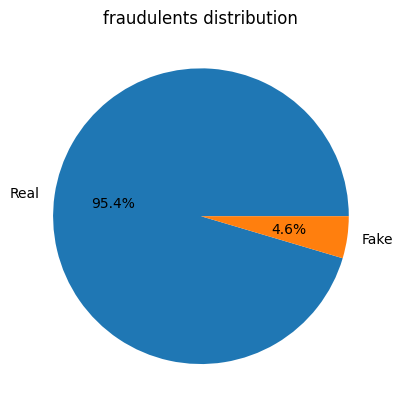

In [145]:
train_y.value_counts().rename(index={0: 'Real', 1: 'Fake'}).plot(kind='pie', autopct='%1.1f%%')
plt.title('fraudulents distribution')
plt.ylabel('')  # y軸ラベルを非表示にする
plt.show()

偽文書と本物文書の割合が不均衡のため、精度だけでモデル性能を評価するのは適切ではない。
不均衡なデータセットでは、多数派クラス（この場合はReal）を予測するだけで高い精度を達成できるため、モデルの真の性能を正確に反映しないことがある。

よって評価にはF1 score（適合率と再現率の調和平均）を用いる。
- 適合率（Precision）
  - 適合率はFakeと予測されたインスタンスのうち、実際にFakeである割合。
  - 積極的にRealと予測するとPrecisionが高くなる
- 再現率（Recall）
  - 再現率は、実際にFakeであるインスタンスのうち、正しくFakeと予測された割合です。
  - 積極的にFakeと予測するとRecallが高くなる
- 両者はトレードオフ関係にあり、バランスが大事

In [146]:
# 利用可能な評価指標
pprint(sorted(_SCORERS.keys()))

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

### 訓練データの加工
前処理を行って、データを扱いやすくする。

#### カテゴリカルデータのエンコード

In [147]:
encoded_train_X = pd.get_dummies(train_X, columns=['employment_type'])
encoded_test_X = pd.get_dummies(test_X, columns=['employment_type'])
print(encoded_train_X.columns)

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'required_experience',
       'required_education', 'industry', 'function',
       'employment_type_Contract', 'employment_type_Full-time',
       'employment_type_Other', 'employment_type_Part-time',
       'employment_type_Temporary'],
      dtype='object')


required_experienceとrequired_educationをレベル別に数値化する。

In [148]:
def int_convert(value):
    try:
        output = int(value)
        return output
    except ValueError:
        return np.nan
    
# required_experience
def encoder_experience(text):
    experience_levels = {
        "Not Applicable": 0,
        "Internship": 1,
        "Entry level": 2,
        "Associate": 3,
        "Mid-Senior level": 4,
        "Director": 5,
        "Executive": 6
    }
    return int_convert(experience_levels.get(text, np.nan))

# required_education
def encoder_education(text):
    education_levels = {
        "Unspecified": 0,
        "Some High School Coursework": 1,
        "High School or equivalent": 2,
        "Vocational - HS Diploma": 2,
        "Some College Coursework Completed": 3,
        "Associate Degree": 4,
        "Vocational - Degree": 5,
        "Certification": 5,
        "Bachelor's Degree": 5,
        "Professional": 6,
        "Master's Degree": 7,
        "Doctorate": 8
    }
    return int_convert(education_levels.get(text, np.nan))

In [149]:
# 二度以上実行するとすべて0になってしまうので注意
encoded_train_X['required_experience'] = encoded_train_X['required_experience'].apply(encoder_experience)
encoded_test_X['required_experience'] = encoded_test_X['required_experience'].apply(encoder_experience)
encoded_train_X['required_education'] = encoded_train_X['required_education'].apply(encoder_education)
encoded_test_X['required_education'] = encoded_test_X['required_education'].apply(encoder_education)

In [150]:
pprint(encoded_train_X['required_experience'].value_counts())
pprint(encoded_train_X['required_education'].value_counts())

required_experience
4.0    918
2.0    646
3.0    565
0.0    284
5.0    106
1.0     88
6.0     41
Name: count, dtype: int64
required_education
5.0    1321
2.0     490
0.0     353
7.0     110
4.0      58
3.0      28
6.0      14
8.0      11
1.0       6
Name: count, dtype: int64


salary_rangeを上限値と下限値でカラムを分ける。

In [151]:
def split_columns_salary(df):
    df['salary_lower'] = df['salary_range'].str.split('-').str[0].apply(int_convert)
    df['salary_upper'] = df['salary_range'].str.split('-').str[1].apply(int_convert)
    df = df.drop('salary_range', axis=1)
    # df['salary_lower'].fillna('null', inplace=True)
    # df['salary_upper'].fillna('null', inplace=True)
    return df

encoded_train_X = split_columns_salary(encoded_train_X)
encoded_test_X = split_columns_salary(encoded_test_X)

In [152]:
pprint(encoded_train_X['salary_lower'].value_counts())
pprint(encoded_train_X['salary_upper'].value_counts())

salary_lower
30000.0     52
40000.0     45
0.0         44
50000.0     35
20000.0     33
            ..
1517.0       1
320000.0     1
4.0          1
78000.0      1
1234.0       1
Name: count, Length: 132, dtype: int64
salary_upper
50000.0     51
40000.0     38
0.0         34
80000.0     33
70000.0     27
            ..
3000.0       1
720000.0     1
27600.0      1
21840.0      1
12345.0      1
Name: count, Length: 151, dtype: int64


地名を国名・州名・都市名で分ける。

In [153]:
def split_columns_location(df):
    df['country'] = df['location'].str.split(', ').str[0]
    df['region'] = df['location'].str.split(', ').str[1]
    df['city'] = df['location'].str.split(', ').str[2]
    df = df.drop('location', axis=1)
    # df['country'].fillna('null', inplace=True)
    # df['region'].fillna('null', inplace=True)
    # df['city'].fillna('null', inplace=True)
    return df

encoded_train_X = split_columns_location(encoded_train_X)
encoded_test_X = split_columns_location(encoded_test_X)

In [154]:
pprint(encoded_train_X['country'].value_counts())
pprint(encoded_train_X['region'].value_counts())
pprint(encoded_train_X['city'].value_counts())

country
US    2663
GB     564
GR     224
CA     126
DE      96
      ... 
KE       1
TT       1
TW       1
CZ       1
TN       1
Name: count, Length: 67, dtype: int64
region
       525
CA     490
NY     291
TX     248
LND    238
      ... 
DUR      1
DNC      1
VAN      1
STT      1
OL       1
Name: count, Length: 219, dtype: int64
city
                     413
London               243
New York             166
Athens               128
San Francisco        123
                    ... 
All of California      1
Mumbai                 1
Patras                 1
Waco                   1
Islamabad              1
Name: count, Length: 1090, dtype: int64


#### Embedding
TF-IDF Vectorizerを用いてベクトル化する場合。

In [155]:
encoded_train_X.columns

Index(['title', 'department', 'company_profile', 'description', 'requirements',
       'benefits', 'telecommuting', 'has_company_logo', 'has_questions',
       'required_experience', 'required_education', 'industry', 'function',
       'employment_type_Contract', 'employment_type_Full-time',
       'employment_type_Other', 'employment_type_Part-time',
       'employment_type_Temporary', 'salary_lower', 'salary_upper', 'country',
       'region', 'city'],
      dtype='object')

In [170]:
text_columns = ['title', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'industry', 'function', 'country',
       'region', 'city']
vectorized_train_X = copy.deepcopy(encoded_train_X)
vectorized_test_X = copy.deepcopy(encoded_test_X)

# ベクトル化
for tc in text_columns:
       vectorizer = TfidfVectorizer()
       vectors_train = vectorizer.fit_transform(encoded_train_X[tc])
       vectors_test = vectorizer.transform(encoded_test_X[tc])
       print(vectors_train.shape)
       print(vectorized_train_X[tc].shape)

       # スパース行列を密な形式に変換
       vectorized_train_X[tc] = pd.DataFrame(vectors_train.toarray(), columns=vectorizer.get_feature_names_out())
       vectorized_test_X[tc] = pd.DataFrame(vectors_test.toarray(), columns=vectorizer.get_feature_names_out())

vectorized_train_X.head()

(4445, 2385)
(4445,)


ValueError: Columns must be same length as key

titleを分割するだけでも2000以上列が増えてしまうため、現実的ではない。

PCAで次元削減するという案もあるが、TF-IDFは単語レベルでしか意味を持たない。よって埋め込みモデルを使ってみる。

In [176]:
model = AutoModel.from_pretrained('jinaai/jina-embeddings-v2-small-en', trust_remote_code=True) # trust_remote_code is needed to use the encode method

ImportError: 
AutoModel requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.


In [ ]:
for tc in text_columns:
       embeddings_train = model.encode(encoded_train_X[tc])
       embeddings_test = model.encode(encoded_test_X[tc])
       print(embeddings_train.shape)
       print(vectorized_train_X[tc].shape)

       # スパース行列を密な形式に変換
       vectorized_train_X[tc] = pd.DataFrame(vectors_train.toarray(), columns=vectorizer.get_feature_names_out())
       vectorized_test_X[tc] = pd.DataFrame(vectors_test.toarray(), columns=vectorizer.get_feature_names_out())

embeddings = model.encode(['How is the weather today?', 'What is the current weather like today?'])

## モデル構築1 (文章加工なし)

GridSearchCVではDMatrixを扱えないので、自分で実装する

In [157]:
model = xgb.XGBClassifier(random_state=0) # fix seed

parameters = {
    "n_estimators" : [10, 20, 50, 100, 200, 500],
    "max_depth" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    'objective' : ['binary:hinge'] # This makes 0 or 1, rather than producing probabilities.
}
model_opt = GridSearchCV(model, parameters, scoring="f1")
model_opt.fit(vectorized_train_X, train_y)
print(model_opt.best_params_)

{'max_depth': 6, 'n_estimators': 100, 'objective': 'binary:hinge'}


In [158]:
print(model_opt.best_score_)

0.3131131865854785


カテゴリカルデータを数値として扱うと精度が悪いので、DMatrixでカテゴリカルデータを正しく扱ってみる。DMatrixを既存のGridSearchCVでは扱えないので、自分で実装する

In [159]:
def GridSearchCV_with_DMatrix(dtrain, parameters):
    res = {
        "best_score": 0,
        "best_params": None
    }

    # パラメータのすべての組み合わせに対してループ
    for params in product(*parameters.values()):
        param_dict = dict(zip(parameters.keys(), params))

        # 警告回避のためnum_roundだけ除外
        given_param = {
            "max_depth" : param_dict["max_depth"],
            'objective' : 'binary:hinge' # This makes 0 or 1, rather than producing probabilities.
        }
        num_round = param_dict["num_round"]
        
        # モデルの訓練と評価
        trained_model = xgb.train(given_param, dtrain, num_round)
        prediceted_y = trained_model.predict(dtest)
        score = f1_score(test_y, prediceted_y)

        # ベストスコアの更新
        if score > res["best_score"]:
            res["best_score"] = score
            res["best_params"] = param_dict
    
    return res

dtrain = xgb.DMatrix(data=vectorized_train_X, label=train_y, enable_categorical=True) # カテゴリカルデータの分類は実験的機能
dtest = xgb.DMatrix(data=vectorized_test_X, label=test_y, enable_categorical=True) # カテゴリカルデータの分類は実験的機能

parameters = {
    "num_round" : [10, 20, 50, 100, 200, 500],
    "max_depth" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
}

result = GridSearchCV_with_DMatrix(dtrain, parameters)
print(result)

{'best_score': 0.5733333333333334, 'best_params': {'num_round': 50, 'max_depth': 10}}


前処理なしでは精度は57%だった。当てずっぽうの50%よりはマシ程度。

## モデル構築2 (文章加工あり)
前処理を行ってからベクトル化する。

In [160]:
# 処理前データ読み込み
processed_columns = ['title', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'industry', 'function']
processed_train_X = copy.deepcopy(encoded_train_X)
processed_test_X = copy.deepcopy(encoded_test_X)

In [161]:
def convert_lower(text):
    try:
        # 英字と空白（スペース、タブ、改行など）以外の文字を取り除く
        cleaned_text = re.sub(r'[^a-zA-Z\s]','',text) 
        lower_text = cleaned_text.lower()
        return lower_text
    except TypeError: # NaNの入力
        return text

# すべて小文字にする
processed_train_X[processed_columns] = processed_train_X[processed_columns].map(convert_lower)
processed_test_X[processed_columns] = processed_test_X[processed_columns].map(convert_lower)

processed_train_X[processed_columns].head()

,title,department,company_profile,description,requirements,benefits,industry,function
0,seeking hospitality security professionals for...,NaN,NaN,please read entire job description and see com...,must be or overhigh school diploma or gedval...,paid days off after year of full time employment,security and investigations,NaN
1,director of it,NaN,industrial color software is a division of ind...,the director of it is responsible for planning...,years of experience managing an it team ...,industrial color offers competitive benefits i...,computer software,management
2,purolator international pricing financial ana...,NaN,pricing recruiters is the leading global resou...,working at purolator international is more tha...,responsible for supporting corporate profit ma...,purolator international provides competitive b...,NaN,NaN
3,general manager knoxville,operations,shyp is the easiest way to send anything anywh...,shyp is looking for the best of the best to le...,years experience with building managing and i...,opportunity to play a huge role in a unicorn s...,logistics and supply chain,management
4,customer service team lead,NaN,novitex enterprise solutions formerly pitney b...,we are currently seeking a customer service te...,required qualificationsexperience coordinating...,NaN,facilities services,customer service


レンマタイゼーション（Lemmatization）によって単語を基本形または辞書形（レンマ）に変換する。

レンマタイゼーションの特徴と利点
- 意味の保持
  - ステミングは単に単語の末尾を切り取る。例えば「running」は「run」になる。
  - レンマタイゼーションは単語の意味を考慮する。例えば「better」のレンマは「good」になる。
- 計算コストが高い

In [162]:
# ワードリストをダウンロード
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# WordNetLemmatizerの初期化
lemmatizer = WordNetLemmatizer()

# NaN対策
def safe_lemmatizer(text):
    try:
        converted_text = lemmatizer.lemmatize(text) 
        return converted_text
    except AttributeError: # NaNの入力
        return text

# レンマタイゼーション
processed_train_X[processed_columns] = processed_train_X[processed_columns].map(safe_lemmatizer)
processed_test_X[processed_columns] = processed_test_X[processed_columns].map(safe_lemmatizer)

processed_train_X[processed_columns].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\katai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\katai\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,title,department,company_profile,description,requirements,benefits,industry,function
0,seeking hospitality security professionals for...,NaN,NaN,please read entire job description and see com...,must be or overhigh school diploma or gedval...,paid days off after year of full time employment,security and investigations,NaN
1,director of it,NaN,industrial color software is a division of ind...,the director of it is responsible for planning...,years of experience managing an it team ...,industrial color offers competitive benefits i...,computer software,management
2,purolator international pricing financial ana...,NaN,pricing recruiters is the leading global resou...,working at purolator international is more tha...,responsible for supporting corporate profit ma...,purolator international provides competitive b...,NaN,NaN
3,general manager knoxville,operation,shyp is the easiest way to send anything anywh...,shyp is looking for the best of the best to le...,years experience with building managing and i...,opportunity to play a huge role in a unicorn s...,logistics and supply chain,management
4,customer service team lead,NaN,novitex enterprise solutions formerly pitney b...,we are currently seeking a customer service te...,required qualificationsexperience coordinating...,NaN,facilities services,customer service


ストップワード（a, an, theなど）の除去

In [163]:
text_columns = ['title', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'industry', 'function', 'country',
       'region', 'city']
vectorized_train_X = copy.deepcopy(processed_train_X)
vectorized_test_X = copy.deepcopy(processed_test_X)

# ストップワードを除去しながらベクトル化
vectorizer = TfidfVectorizer(stop_words='english', binary=False)
vectors_train = vectorizer.fit_transform(processed_train_X[text_columns])
vectors_test = vectorizer.transform(processed_test_X[text_columns])

# スパース行列を密な形式に変換
vectorized_train_X[text_columns] = pd.DataFrame(vectors_train.toarray(), columns=vectorizer.get_feature_names_out(), dtype="float")
vectorized_test_X[text_columns] = pd.DataFrame(vectors_test.toarray(), columns=vectorizer.get_feature_names_out(), dtype="float")

vectorized_train_X.head()

,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,required_experience,...,employment_type_Contract,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,salary_lower,salary_upper,country,region,city
0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0.0,...,False,True,False,False,False,NaN,NaN,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,...,False,True,False,False,False,NaN,NaN,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,NaN,...,False,True,False,False,False,NaN,NaN,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0,4.0,...,False,True,False,False,False,NaN,NaN,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,2.0,...,False,True,False,False,False,NaN,NaN,0.0,1.0,0.0


学習

In [164]:
dtrain = xgb.DMatrix(data=vectorized_train_X, label=train_y, enable_categorical=True) # カテゴリカルデータの分類は実験的機能
dtest = xgb.DMatrix(data=vectorized_test_X, label=test_y, enable_categorical=True) # カテゴリカルデータの分類は実験的機能

parameters = {
    "num_round" : [10, 20, 50, 100, 200, 500],
    "max_depth" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
}

result = GridSearchCV_with_DMatrix(dtrain, parameters)
print(result)

{'best_score': 0.5733333333333334, 'best_params': {'num_round': 50, 'max_depth': 10}}


結果は変わらなかった。
# モデル構築3 (不要列削除)
ノイズとなる情報を削除し、重要な情報だけ用いて学習する。

In [165]:
vectorized_train_X.columns

Index(['title', 'department', 'company_profile', 'description', 'requirements',
       'benefits', 'telecommuting', 'has_company_logo', 'has_questions',
       'required_experience', 'required_education', 'industry', 'function',
       'employment_type_Contract', 'employment_type_Full-time',
       'employment_type_Other', 'employment_type_Part-time',
       'employment_type_Temporary', 'salary_lower', 'salary_upper', 'country',
       'region', 'city'],
      dtype='object')

In [166]:
encoded_train_X.head()

,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,required_experience,...,employment_type_Contract,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,salary_lower,salary_upper,country,region,city
0,Seeking Hospitality Security Professionals for...,NaN,NaN,***PLEASE READ ENTIRE JOB DESCRIPTION AND SEE ...,Must be 21 or overHigh School diploma or G.E....,Paid days off after 1 year of full time employ...,0,0,1,0.0,...,False,True,False,False,False,NaN,NaN,US,NY,New York
1,Director of IT,NaN,Industrial Color Software is a division of Ind...,The Director of IT is responsible for planning...,• 2+ years of experience managing an IT team...,Industrial Color offers competitive benefits i...,0,1,0,0.0,...,False,True,False,False,False,NaN,NaN,US,NY,New York
2,Purolator International - Pricing Financial An...,NaN,Pricing Recruiters is the leading global resou...,Working at Purolator International is more tha...,Responsible for supporting corporate profit ma...,Purolator International Provides Competitive B...,0,1,0,NaN,...,False,True,False,False,False,NaN,NaN,US,NY,Jericho
3,General Manager - Knoxville,Operations,"Shyp is the easiest way to send anything, anyw...",Shyp is looking for the best of the best to le...,"5+ years experience with building, managing, a...",Opportunity to play a huge role in a unicorn s...,0,1,0,4.0,...,False,True,False,False,False,NaN,NaN,US,TN,Knoxville
4,Customer Service Team Lead,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",We are currently seeking a Customer Service Te...,Required Qualifications:Experience coordinatin...,NaN,0,1,0,2.0,...,False,True,False,False,False,NaN,NaN,US,AZ,Tempe
